In [1]:
# load required libraries & modules
%load_ext autoreload
%autoreload 2

import os
from tqdm.notebook import tqdm
import pprint
import time
import warnings
# warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import torch

from utils import *
from loaddata import *
from visualization import *
from ourmodel import *

torch.set_grad_enabled(False)
torch.set_printoptions(sci_mode=False)

DATA_DIR = '../data'
DEVICE = torch.device('cuda:1' if torch.cuda.is_available() else 'cpu')
# DEVICE = torch.device('cpu')

BATCHSIZE = 1000

PATH_MNISTC = '../data/MNIST_C/'
CORRUPTION_TYPES = ['identity', 
         'shot_noise', 'impulse_noise','glass_blur','motion_blur',
         'shear', 'scale',  'rotate',  'brightness',  'translate',
         'stripe', 'fog','spatter','dotted_line', 'zigzag',
         'canny_edges']

CORRUPTION_INTEREST = ['glass_blur','motion_blur', 'impulse_noise','shot_noise',
        'fog','dotted_line','spatter', 'zigzag']

ACC_TYPE = "entropy"

#################
# model load
################
def load_model(args):
    # load model
    model = RRCapsNet(args).to(args.device) 
    model.load_state_dict(torch.load(args.load_model_path))
    return model

def load_args(load_model_path, args_to_update, verbose=False):
    params_filename = os.path.dirname(load_model_path) + '/params.txt'
    assert os.path.isfile(params_filename), "No param flie exists"
    args = parse_params_wremove(params_filename, removelist = ['device']) 
    args = update_args(args, args_to_update)
    args.load_model_path = load_model_path
    if verbose:
        pprint.pprint(args.__dict__, sort_dicts=False)
    return args

############
# testing 
############
def predict(model, args, x):    
    with torch.no_grad():        
        objcaps_len_step, x_recon_step = model(x)
    return objcaps_len_step, x_recon_step

    
def load_dataloader_for_each_corruption(path_mnistc, corruption):
    path_images = os.path.join(path_mnistc, corruption, 'test_images.npy')
    path_labels = os.path.join(path_mnistc, corruption, 'test_labels.npy')

    # convert to torch
    images = np.load(path_images)
    labels = np.load(path_labels)
    transform_tohot = T.Lambda(lambda y: torch.zeros(10, dtype=torch.float).scatter_(0, torch.tensor(y), value=1))
    images_tensorized = torch.stack([T.ToTensor()(im) for im in images])
    labels_tensorized = torch.stack([transform_tohot(label) for label in labels])
    # print(images_tensorized.shape) #torch.Size([10000, 1, 28, 28])
    # print(labels_tensorized.shape) #torch.Size([10000, 10])

    # create dataloader
    kwargs = {'num_workers': 1, 'pin_memory': True} if DEVICE == 'cuda' else {}
    dataset = TensorDataset(images_tensorized, labels_tensorized)
    dataloader = DataLoader(dataset, batch_size=BATCHSIZE, shuffle=False, drop_last=False, **kwargs)

    return dataloader


def test_model_on_dataloader(model, args, dataloader, acc_type=ACC_TYPE):
    acclist = []
    nsteplist = []
    
    model.eval()
    
    # load batch data
    for data in dataloader:
        if len(data)==2:
            x, y = data
            gtx = None
            x= x.to(args.device) 
            y= y.to(args.device) 

        elif len(data)==3:
            x, gtx, y = data
            x= x.to(args.device) 
            y= y.to(args.device) 
            gtx =gtx.to(args.device) 
        num_classes = y.size(dim=1) #onehot vector

        # predict
        objcaps_len_step, x_recon_step = predict(model, args, x)
        objcaps_len_step_narrow = objcaps_len_step.narrow(dim=-1,start=0, length=num_classes) # in case a background cap was added    

        # evaluate
        if acc_type == 'entropy':
            if args.time_steps==1:
                y_pred = objcaps_len_step_narrow[:,-1]
                accs = topkacc(y_pred, y, topk=1)
                nstep = torch.ones(accs.size(), device=accs.device)
            else:
                accs, final_pred, nstep, no_stop_condition, entropy = compute_entropy_based_acc(objcaps_len_step_narrow, y,  threshold=0.6, use_cumulative = False, only_acc=False)
        else:
            raise NotImplementedError

        acclist.append(accs) 
        nsteplist.append(nstep)
        
    # average acc and nstep (on accurate trials)
    cataccs = torch.cat(acclist)
    catnsteps = torch.cat(nsteplist)
    acc_mean = cataccs.mean().item()
#     (accs*nstep).sum()/((accs*nstep)!=0).sum()
    nstep_mean_correct =(cataccs*catnsteps).sum().item()/((cataccs*catnsteps)!=0).sum().item()
#     nstep_mean = torch.cat(nsteplist).to(torch.float).mean().item()
    
    return acc_mean, nstep_mean_correct


    



# Generate Results on MNIST-C

In [6]:
########################################################
# best model comparison on entire corruptions
########################################################
verbose=False
print_args =False
args_to_update = {'device':DEVICE, 'batch_size':BATCHSIZE, 
                 'time_steps': 5, 'routings': 3, 'mask_threshold': 0.1}

modelpathlist = [
# cnn 2 layers - lsf
#  './models/our-2conv/run1.pt',
#  './models/our-2conv/run2.pt',
#  './models/our-2conv/run3.pt',
#  './models/our-2conv/run4.pt',
#  './models/our-2conv/run5.pt'
    
# resnet 4 layers - lsf
 './models/our-resnet/run1.pt',
 './models/our-resnet/run2.pt',
 './models/our-resnet/run3.pt',
 './models/our-resnet/run4.pt',
 './models/our-resnet/run5.pt'
]


df_acc = pd.DataFrame()
df_rt = pd.DataFrame()

df_acc['corruption'] = CORRUPTION_TYPES
df_rt['corruption'] = CORRUPTION_TYPES

for load_model_path in modelpathlist:    
#     modelname = '-'.join( os.path.dirname(load_model_path).split('_')[-3:-1]) #'recon-step3'
    modelname = load_model_path.split('/')[-1] # filename
    print(f'test starts on {modelname}')
    
    # load args and model  
    args = load_args(load_model_path, args_to_update, print_args)
    model = load_model(args)
    
    accmean, rtmean = [], []
    for corruption in CORRUPTION_TYPES:
        dataloader = load_dataloader_for_each_corruption(PATH_MNISTC, corruption)
        am, rm = test_model_on_dataloader(model, args, dataloader) # average performance per corruption
        accmean.append(am*100)
        rtmean.append(rm)
        
    df_acc[load_model_path] = accmean 
    df_rt[load_model_path] = rtmean 


df_acc.index = np.arange(1, len(df_acc)+1)
df_rt.index = np.arange(1, len(df_rt)+1)


#### generate summary data
df_acc_summary = pd.DataFrame()
df_rt_summary = pd.DataFrame()

for i, load_model_path in enumerate(modelpathlist):
    df_acc_summary.loc['average', load_model_path] = df_acc.loc[:,load_model_path].mean()
    df_acc_summary.loc['shape', load_model_path] = df_acc.loc[df_acc['corruption'].isin(CORRUPTION_INTEREST),load_model_path].mean()
    df_rt_summary.loc['average', load_model_path] = df_rt.loc[:,load_model_path].mean()
    df_rt_summary.loc['shape', load_model_path] = df_rt.loc[df_rt['corruption'].isin(CORRUPTION_INTEREST),load_model_path].mean()

print("\n==== average ACC for each corruption ====")
display(df_acc)
display(df_acc_summary)

print("\n==== average RT for each corruption ====")
display(df_rt)
display(df_rt_summary)



test starts on run1.pt

=========== model instantiated like below: =============
TASK: mnist_recon_low (# targets: 1, # classes: 10, # background: 0)
TIMESTEPS #: 5
ENCODER: resnet w/ None projection
...resulting primary caps #: 288, dim: 8
ROUTINGS # 3
Object #: 10, BG Capsule #: 0
DECODER: fcn, w/ None projection
...recon only one object capsule: True
...use recon mask for attention: True
...with mask type bool, threshold 0.1, apply_method match

test starts on run2.pt

=========== model instantiated like below: =============
TASK: mnist_recon_low (# targets: 1, # classes: 10, # background: 0)
TIMESTEPS #: 5
ENCODER: resnet w/ None projection
...resulting primary caps #: 288, dim: 8
ROUTINGS # 3
Object #: 10, BG Capsule #: 0
DECODER: fcn, w/ None projection
...recon only one object capsule: True
...use recon mask for attention: True
...with mask type bool, threshold 0.1, apply_method match

test starts on run3.pt

=========== model instantiated like below: =============
TASK: mnist_r

,corruption,./models/our-resnet/run1.pt,./models/our-resnet/run2.pt,./models/our-resnet/run3.pt,./models/our-resnet/run4.pt,./models/our-resnet/run5.pt
1,identity,99.379998,99.429995,99.489999,99.339998,99.409997
2,shot_noise,97.659999,97.649997,97.749996,97.969997,97.069997
3,impulse_noise,97.029996,97.160000,96.579999,96.319997,97.340000
4,glass_blur,94.119996,94.849998,94.879997,95.899999,93.479997
5,motion_blur,96.679997,95.919997,96.329999,96.499997,96.619999
6,shear,98.219997,98.539996,98.369998,98.279995,98.319995
7,scale,96.249998,96.039999,97.270000,96.929997,96.649998
8,rotate,93.869996,94.099998,93.899995,94.379997,94.059998
9,brightness,99.079996,99.329996,97.770000,99.119997,99.179995
10,translate,58.450001,58.359998,58.129996,58.050001,59.169996


,./models/our-resnet/run1.pt,./models/our-resnet/run2.pt,./models/our-resnet/run3.pt,./models/our-resnet/run4.pt,./models/our-resnet/run5.pt
average,92.583123,91.034998,91.241873,92.213747,92.131247
shape,96.557498,96.817498,94.957498,96.576247,96.307498



==== average RT for each corruption ====


,corruption,./models/our-resnet/run1.pt,./models/our-resnet/run2.pt,./models/our-resnet/run3.pt,./models/our-resnet/run4.pt,./models/our-resnet/run5.pt
1,identity,1.027269,1.025546,1.028546,1.017717,1.028669
2,shot_noise,1.047819,1.037276,1.034783,1.037563,1.050994
3,impulse_noise,1.280841,1.194113,1.297888,1.245432,1.284159
4,glass_blur,1.206332,1.167949,1.183706,1.129197,1.215661
5,motion_blur,1.134154,1.153148,1.176061,1.100829,1.201925
6,shear,1.104968,1.096509,1.092711,1.067969,1.111168
7,scale,1.294753,1.364744,1.233988,1.209842,1.271909
8,rotate,1.222116,1.214984,1.177955,1.156495,1.234425
9,brightness,1.924405,1.793819,1.951519,1.875000,1.980137
10,translate,1.996749,2.014222,2.001548,1.770198,2.021802


,./models/our-resnet/run1.pt,./models/our-resnet/run2.pt,./models/our-resnet/run3.pt,./models/our-resnet/run4.pt,./models/our-resnet/run5.pt
average,1.399366,1.411537,1.390542,1.351878,1.409506
shape,1.261787,1.235491,1.285528,1.238479,1.276271


In [71]:
def save_to_csv(df, path_file, overwrite=False):
    if os.path.isfile(path_file) and not overwrite:
        print(f'file {path_file} already exists, df is not saved')
    else: 
        df.to_csv(path_file, index=False)
        print(f'df is saved to csv as {path_file}')   
        
#peformance results file save
# modelname= 'rrcapsnet-lowpass-resnet4' ###### double check model name is correct
# modelname= 'rrcapsnet-lowpass-conv2' ###### double check model name is correct
modelname= 'rrcapsnet-highpass-resnet4' ###### double check model name is correct
# modelname= 'rrcapsnet-fullpass-resnet4' ###### double check model name is correct

overwrite = True
path_accdf = f'./performance/acc-{modelname}-G{args.time_steps}L{args.routings}.csv'
path_rtdf = f'./performance/rt-{modelname}-G{args.time_steps}L{args.routings}.csv'

save_to_csv(df_rt, path_rtdf, overwrite=overwrite)
save_to_csv(df_acc, path_accdf, overwrite=overwrite)

df is saved to csv as ./performance/rt-rrcapsnet-highpass-resnet4-G1L1.csv
df is saved to csv as ./performance/acc-rrcapsnet-highpass-resnet4-G1L1.csv


# Average performance on MNIST-C and MNIST-C shape

In [8]:
path_file = './results/performance/acc-rrcapsnet-lowpass-resnet4-G5L3.csv'
# path_file = './performance/acc-rrcapsnet-lowpass-conv2-G5L3.csv'

# load result file
res = pd.read_csv(path_file)
# res.columns = ['corruption', 'run1', 'run2', 'run3', 'run4', 'run5']
modellist = list(res)[1:]

# generate summary data
df_summary = pd.DataFrame()

for i, load_model_path in enumerate(modellist):
    df_summary.loc['average', load_model_path] = res.loc[:,load_model_path].mean()
    df_summary.loc['shape', load_model_path] = res.loc[res['corruption'].isin(CORRUPTION_INTEREST),load_model_path].mean()

display(df_summary)
print('\nmean: ')
display((df_summary[modellist].mean(axis=1)).round(2))
print('\nstd: ')
display((df_summary[modellist].std(axis=1)).round(2))


,./results/mnist/Aug14_0508_lsf_res4_run1/best_epoch30_acc1.0000.pt,./results/mnist/Aug14_0524_lsf_res4_run2/best_epoch29_acc1.0000.pt,./results/mnist/Aug14_0540_lsf_res4_run3/best_epoch26_acc1.0000.pt,./results/mnist/Aug14_0556_lsf_res4_run4/best_epoch29_acc1.0000.pt,./results/mnist/Aug14_0612_lsf_res4_run5/best_epoch28_acc1.0000.pt
average,92.583123,91.034998,91.241873,92.213747,92.131247
shape,96.557498,96.817498,94.957498,96.576247,96.307498



mean: 


average    91.84
shape      96.24
dtype: float64


std: 


average    0.67
shape      0.74
dtype: float64

# ACC on Individual Corruption

In [14]:
import pandas as pd
import numpy as np
import os

from scipy import stats
from pingouin import ttest, anova, pairwise_tests
import matplotlib.pyplot as plt
colors = ["xkcd:light grey",  '#ff76c0',  "xkcd:light blue"]


In [5]:
CORRUPTION_TYPES = ['identity', 
         'shot_noise', 'impulse_noise','glass_blur','motion_blur',
         'shear', 'scale',  'rotate',  'brightness',  'translate',
         'stripe', 'fog','spatter','dotted_line', 'zigzag',
         'canny_edges']

CORRUPTION_INTEREST=[
#  'shear',
#  'rotate',
#  'scale',
#  'translate',
#  'stripe',
    
 'glass_blur',
 'motion_blur',
    
 'impulse_noise',
 'shot_noise',
        
 'fog',
 'dotted_line',    
 'spatter',
 'zigzag',
    
#  'brightness',
#  'canny_edges',
]

clist_to_plot = CORRUPTION_INTEREST

# get model avg and sd on shape set and add as separate columns to df
def add_avg_std_columns(df, avg_colname='avg', sd_colname='sd'):

    df.columns = ['corruption', 'run1', 'run2', 'run3', 'run4', 'run5']
    df = df[df['corruption'].isin(CORRUPTION_TYPES)]
    df.loc[:,avg_colname] = df[['run1', 'run2', 'run3', 'run4', 'run5']].mean(axis=1)
    df.loc[:,sd_colname] = df[['run1', 'run2', 'run3', 'run4', 'run5']].std(axis=1)

    model_avg = df[['run1', 'run2', 'run3', 'run4', 'run5']].mean()
    print('\n==All==\naverage: ', round(model_avg.mean(),2), '\nsd: ', round(model_avg.std(),2))

    df_select = df[df['corruption'].isin(CORRUPTION_INTEREST)].copy()
    df_select.loc[:,avg_colname] = df_select[['run1', 'run2', 'run3', 'run4', 'run5']].mean(axis=1)
    df_select.loc[:,sd_colname] = df_select[['run1', 'run2', 'run3', 'run4', 'run5']].std(axis=1)

    model_avg = df_select[['run1', 'run2', 'run3', 'run4', 'run5']].mean()
    print('\n==Shape==\naverage: ', round(model_avg.mean(),2), '\nsd: ', round(model_avg.std(),2))
    
    return df_select

In [6]:
# our
print('\n===load our ===')
path_model_performance = '../results/performance/acc-rrcapsnet-lowpass-resnet4-G5L3.csv'
# path_model_performance = './results/rrcapsnet-lowpass-conv2l-G5L3.csv'

df = pd.read_csv(path_model_performance)
if df.iloc[:,-1].mean() < 1.0:
    print("changed to percent")
    df.iloc[:,1:] = df.iloc[:,1:]*100
our = add_avg_std_columns(df, avg_colname= 'our', sd_colname= 'our.sd')

# cnn
print('\n===load CNN===')
path_model_performance = '../results/performance/acc-cnn.csv' #'./results/model-results-cnn-clean-resnet4.csv'
df = pd.read_csv(path_model_performance)
cnn = add_avg_std_columns(df, avg_colname= 'cnn', sd_colname= 'cnn.sd')

# capsnet
print('\n===load capsnet===')
path_model_performance = '../results/performance/acc-capsnet.csv' #'./results/model-results-cnn-clean-resnet4.csv'
df = pd.read_csv(path_model_performance)
capsnet = add_avg_std_columns(df, avg_colname= 'capsnet', sd_colname= 'capsnet.sd')

# merge results for model comparison
result = our[['corruption', 'our', 'our.sd']].merge(cnn[['corruption', 'cnn', 'cnn.sd']], left_on='corruption', right_on='corruption')
result = result.merge(capsnet[['corruption', 'capsnet', 'capsnet.sd']], left_on='corruption', right_on='corruption')
result


===load our ===

==All==
average:  91.84 
sd:  0.67

==Shape==
average:  96.24 
sd:  0.74

===load CNN===

==All==
average:  88.94 
sd:  0.64

==Shape==
average:  91.8 
sd:  0.88

===load capsnet===

==All==
average:  75.14 
sd:  1.0

==Shape==
average:  81.87 
sd:  0.55


,corruption,our,our.sd,cnn,cnn.sd,capsnet,capsnet.sd
0,shot_noise,97.619997,0.333317,97.317997,0.135537,97.884005,0.047749
1,impulse_noise,96.885998,0.423061,90.875999,1.844718,86.252004,2.521076
2,glass_blur,94.645997,0.909000,90.173998,0.764808,88.168004,0.859139
3,motion_blur,96.409998,0.304796,92.155998,1.520453,84.496004,1.718322
4,fog,94.561998,5.812726,76.931997,4.600257,21.340001,0.926823
5,spatter,98.103998,0.255109,98.187998,0.124379,96.674004,0.266609
6,dotted_line,98.579998,0.249702,98.319997,0.136931,96.234005,0.413316
7,zigzag,93.137999,0.921993,90.411998,0.776544,83.946004,0.771771


In [7]:
# statistical test
for corruption in clist_to_plot:
    if corruption in CORRUPTION_TYPES:
        print(f'stat analysis on : {corruption}')
        cnn_5runs_corruption=our[our.corruption==corruption][['run1','run2','run3','run4','run5']].values[0]
        our_5runs_corruption=cnn[cnn.corruption==corruption][['run1','run2','run3','run4','run5']].values[0]
        display(ttest(cnn_5runs_corruption, our_5runs_corruption, paired=False).round(3))

stat analysis on : glass_blur


,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power
T-test,8.418,8,two-sided,0.0,"[3.25, 5.7]",5.324,443.708,1.0


stat analysis on : motion_blur


,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power
T-test,6.134,8,two-sided,0.0,"[2.65, 5.85]",3.88,73.366,1.0


stat analysis on : impulse_noise


,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power
T-test,7.101,8,two-sided,0.0,"[4.06, 7.96]",4.491,164.028,1.0


stat analysis on : shot_noise


,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power
T-test,1.877,8,two-sided,0.097,"[-0.07, 0.67]",1.187,1.263,0.38


stat analysis on : fog


,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power
T-test,5.318,8,two-sided,0.001,"[9.99, 25.27]",3.363,35.339,0.996


stat analysis on : dotted_line


,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power
T-test,2.041,8,two-sided,0.075,"[-0.03, 0.55]",1.291,1.46,0.435


stat analysis on : spatter


,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power
T-test,-0.662,8,two-sided,0.527,"[-0.38, 0.21]",0.419,0.564,0.09


stat analysis on : zigzag


,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power
T-test,5.057,8,two-sided,0.001,"[1.48, 3.97]",3.198,27.7,0.992


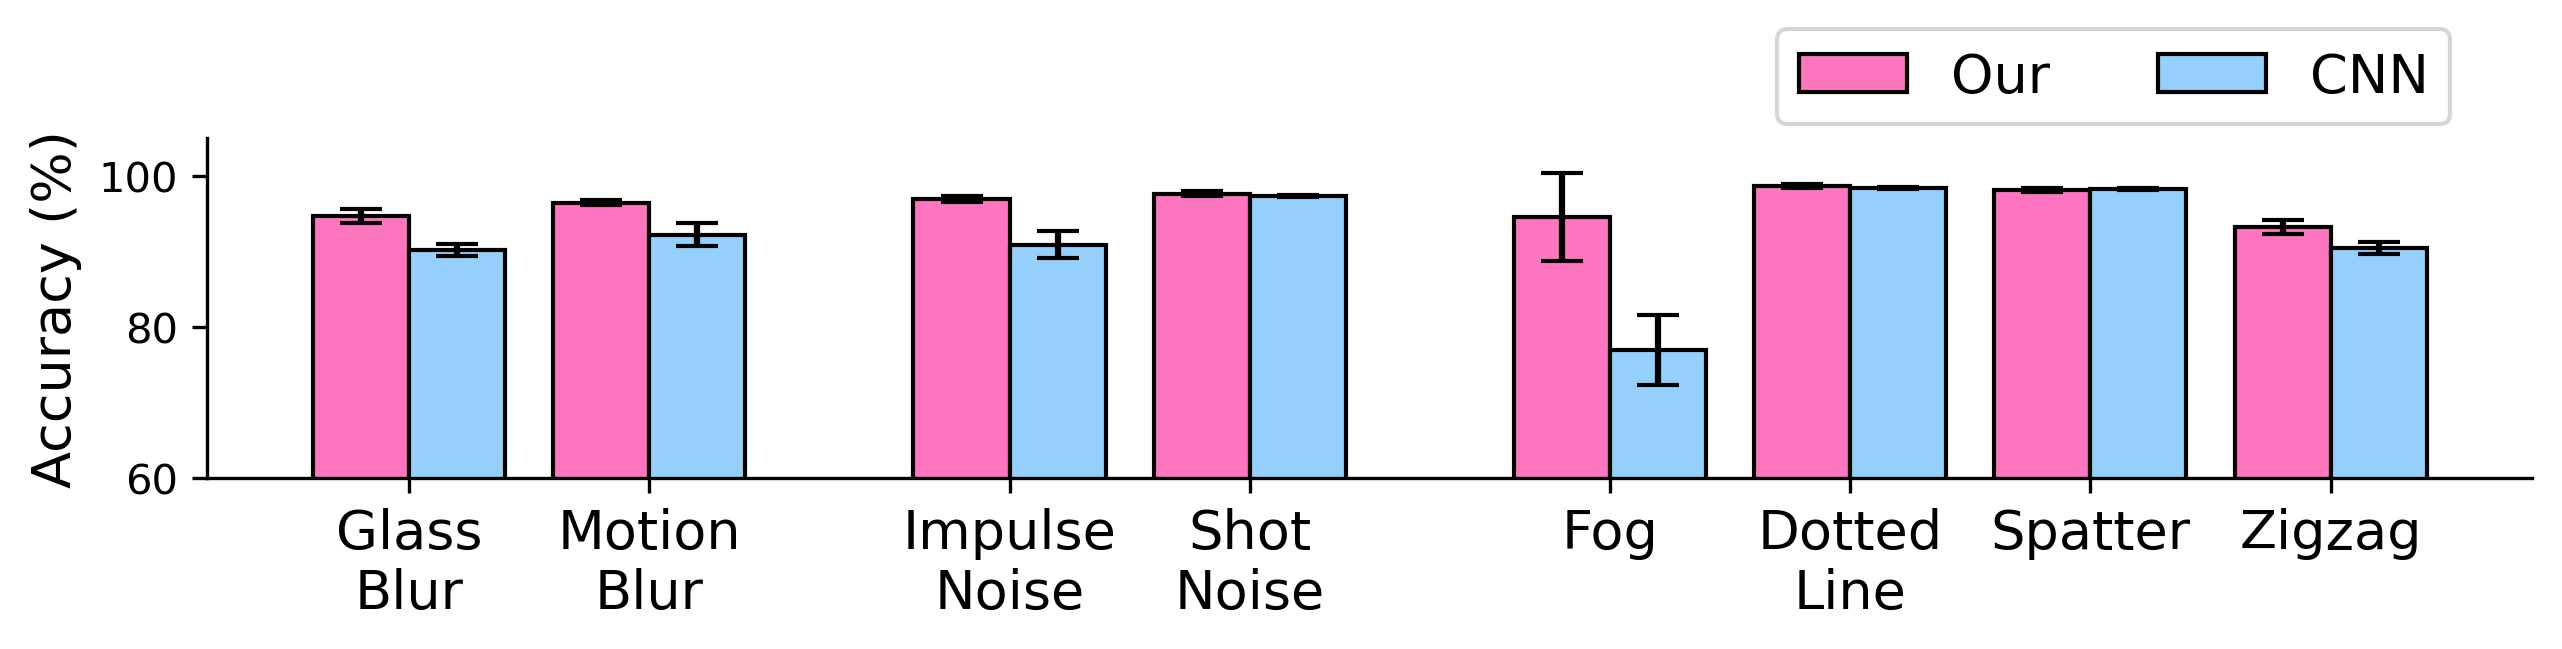

In [14]:
# comparison plot
colors = ["xkcd:light grey",  '#ff76c0',  "xkcd:light blue"]
clist_to_plot = CORRUPTION_INTEREST
X_means, X_ses = [], []
Y_means, Y_ses = [], []
for corruption in clist_to_plot:
    if corruption in CORRUPTION_TYPES:
#         print(f'stat analysis on : {corruption}')
#         display(ttest(cnn_5runs_corruption, our_5runs_corruption, paired=False).round(4))
        # data for plotting
        X_means.append(result[result.corruption==corruption]['cnn'].item())
        X_ses.append(result[result.corruption==corruption]['cnn.sd'].item())
        Y_means.append(result[result.corruption==corruption]['our'].item())
        Y_ses.append(result[result.corruption==corruption]['our.sd'].item()) 
    else:
        # data for plotting
        X_means.append(0)
        X_ses.append(0)
        Y_means.append(0)
        Y_ses.append(0)    
    

plt.rcParams["figure.figsize"] = (10,1.5)

labels = clist_to_plot
labels = ['Glass\nBlur', 'Motion\nBlur','Impulse\nNoise','Shot\nNoise',
                 'Fog', 'Dotted\nLine', 'Spatter', 'Zigzag']
x =np.array([0, 1,  2.5, 3.5,  5, 6, 7, 8])  # the label locations
width = 0.4 # the width of the bars

fig, ax = plt.subplots(dpi=300)
rects1 = ax.bar(x - width/2, Y_means, width, label='Our', edgecolor = 'black', color = colors[1], yerr=Y_ses, capsize=5)
rects2 = ax.bar(x + width/2, X_means, width, label='CNN', edgecolor = 'black', color =colors[2], yerr=X_ses, capsize=5)



# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Accuracy (%)', fontsize=13)
ax.set_title('')
ax.set_xticks(x, labels=labels, fontsize=13, rotation=0)
ax.legend(fontsize=13, ncol=2, loc="upper center", bbox_to_anchor=(0.82,1.4))
# ax.legend(fontsize=13, ncol=2, loc="upper left", bbox_to_anchor=(-0.05,1.5))
ax.set_ylim(60, 105)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

# ax.bar_label(rects1, padding=3)
# ax.bar_label(rects2, padding=3)

# plt.tight_layout()
plt.show()
fig.savefig("../results/figures-ploscomp/individual-acc.pdf", dpi=300, bbox_inches='tight')

# RT on Individual Corruption

In [11]:
# our resnet4
print("<<<RESNET")
path_model_performance = '../results/performance/rt-rrcapsnet-lowpass-resnet4-G5L3.csv'
df = pd.read_csv(path_model_performance)
if df.iloc[:,-1].mean() < 1.0:
    print("changed to percent")
    df.iloc[:,1:] = df.iloc[:,1:]*100
our = add_avg_std_columns(df, avg_colname= 'our', sd_colname= 'our.sd')

# our conv2
print("\n\n<<<CONV")
path_model_performance = '../results/performance/rt-rrcapsnet-lowpass-conv2-G5L3.csv'
df = pd.read_csv(path_model_performance)
if df.iloc[:,-1].mean() < 1.0:
    print("changed to percent")
    df.iloc[:,1:] = df.iloc[:,1:]*100
our_conv = add_avg_std_columns(df, avg_colname= 'our-conv', sd_colname= 'our-conv.sd')

# merge results for model comparison
result = our[['corruption', 'our', 'our.sd']].merge(our_conv[['corruption', 'our-conv', 'our-conv.sd']], left_on='corruption', right_on='corruption')
# result = result.merge(our_ff[['corruption', 'our-ff', 'our-ff.sd']], left_on='corruption', right_on='corruption')
result

<<<RESNET

==All==
average:  1.39 
sd:  0.02

==Shape==
average:  1.26 
sd:  0.02


<<<CONV

==All==
average:  4.47 
sd:  0.03

==Shape==
average:  4.52 
sd:  0.03


,corruption,our,our.sd,our-conv,our-conv.sd
0,shot_noise,1.041687,0.007217,4.783501,0.018670
1,impulse_noise,1.260486,0.041850,4.617720,0.041096
2,glass_blur,1.180569,0.034291,4.979368,0.017589
3,motion_blur,1.153224,0.038737,4.998469,0.000789
4,fog,2.046755,0.103536,4.917184,0.073662
5,spatter,1.077788,0.011501,4.178450,0.061576
6,dotted_line,1.082544,0.009427,3.819647,0.064431
7,zigzag,1.233038,0.025094,3.896982,0.073507


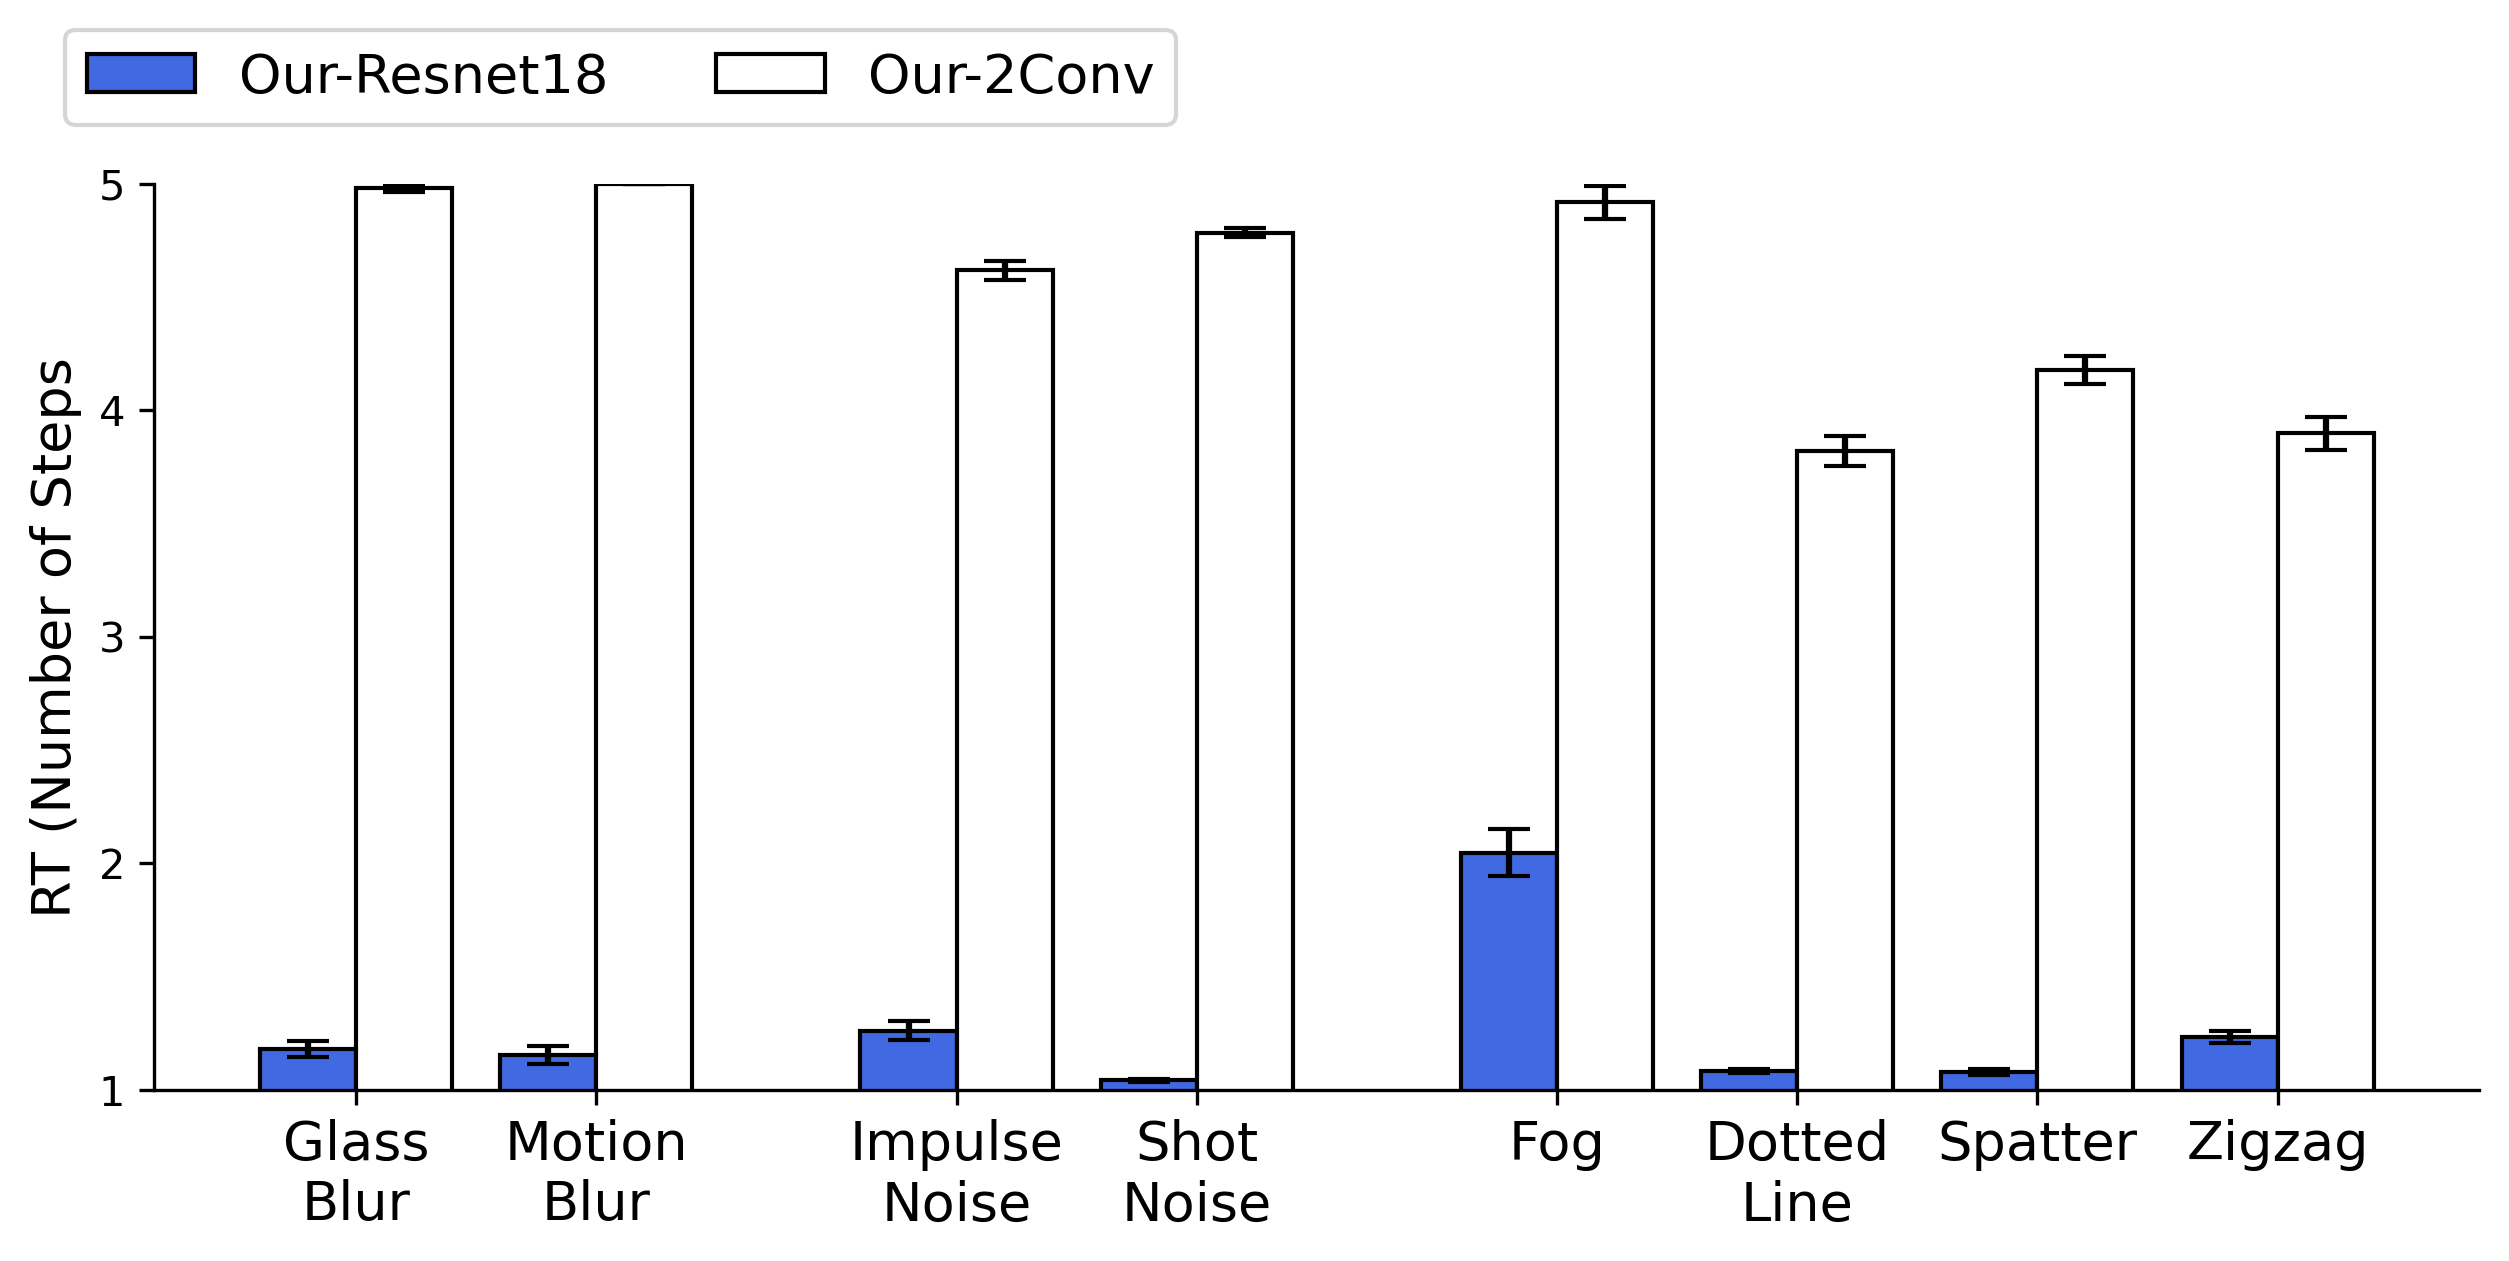

In [19]:
# comparison plot
clist_to_plot = CORRUPTION_INTEREST
X_means, X_ses = [], []
Y_means, Y_ses = [], []
for corruption in clist_to_plot:
    if corruption in CORRUPTION_TYPES:
#         print(f'stat analysis on : {corruption}')
#         display(ttest(cnn_5runs_corruption, our_5runs_corruption, paired=False).round(4))
        # data for plotting
        X_means.append(result[result.corruption==corruption]['our-conv'].item())
        X_ses.append(result[result.corruption==corruption]['our-conv.sd'].item())
        Y_means.append(result[result.corruption==corruption]['our'].item())
        Y_ses.append(result[result.corruption==corruption]['our.sd'].item()) 
    else:
        # data for plotting
        X_means.append(0)
        X_ses.append(0)
        Y_means.append(0)
        Y_ses.append(0)    
    

plt.rcParams["figure.figsize"] = (10,4)

labels = clist_to_plot
labels = ['Glass\nBlur', 'Motion\nBlur','Impulse\nNoise','Shot\nNoise',
                 'Fog', 'Dotted\nLine', 'Spatter', 'Zigzag']
x =np.array([0, 1,  2.5, 3.5,  5, 6, 7, 8])  # the label locations
width = 0.4 # the width of the bars

fig, ax = plt.subplots(dpi=300)
rects1 = ax.bar(x - width/2, Y_means, width, label='Our-Resnet18', edgecolor = 'black', color = 'royalblue', yerr=Y_ses, capsize=5)
rects2 = ax.bar(x + width/2, X_means, width, label='Our-2Conv', edgecolor = 'black', color ='white', yerr=X_ses, capsize=5)

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('RT (Number of Steps', fontsize=13)
ax.set_title('')
ax.set_xticks(x, labels=labels, fontsize=13, rotation=0)
# ax.legend(fontsize=13, ncol=2, loc="upper center", bbox_to_anchor=(0.85,1.4))
ax.legend(fontsize=13, ncol=2, loc="upper left", bbox_to_anchor=(-0.05,1.2))
ax.set_ylim(1.0, 5.0)
ax.set_yticks([1,2,3,4,5])
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

# ax.bar_label(rects1, padding=3)
# ax.bar_label(rects2, padding=3)

# plt.tight_layout()
plt.show()
fig.savefig("../results/figures/individual-rt.pdf", dpi=300, bbox_inches='tight')

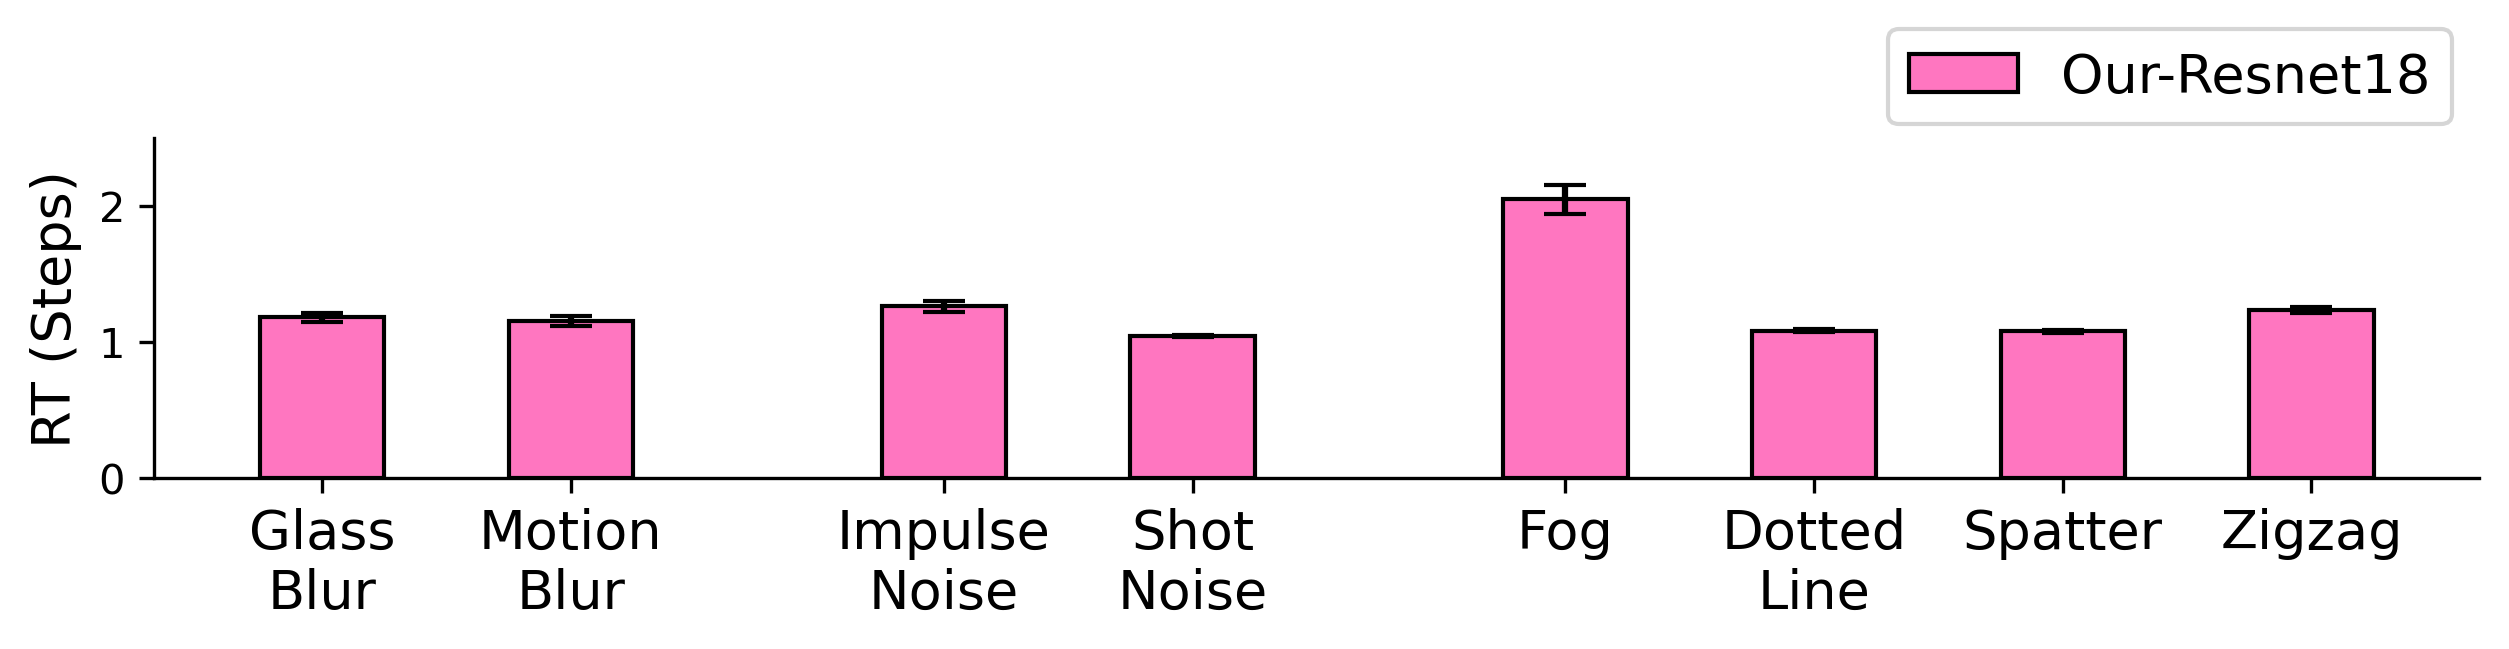

In [21]:
# individual plot
clist_to_plot = CORRUPTION_INTEREST
X_means, X_ses = [], []
Y_means, Y_ses = [], []
for corruption in clist_to_plot:
    if corruption in CORRUPTION_TYPES:
#         print(f'stat analysis on : {corruption}')
#         display(ttest(cnn_5runs_corruption, our_5runs_corruption, paired=False).round(4))
        # data for plotting
        X_means.append(result[result.corruption==corruption]['our-conv'].item())
        X_ses.append(result[result.corruption==corruption]['our-conv.sd'].item())
        Y_means.append(result[result.corruption==corruption]['our'].item())
        Y_ses.append(result[result.corruption==corruption]['our.sd'].item()) 
    else:
        # data for plotting
        X_means.append(0)
        X_ses.append(0)
        Y_means.append(0)
        Y_ses.append(0)    
    

plt.rcParams["figure.figsize"] = (10,1.5)

labels = clist_to_plot
labels = ['Glass\nBlur', 'Motion\nBlur','Impulse\nNoise','Shot\nNoise',
                 'Fog', 'Dotted\nLine', 'Spatter', 'Zigzag']
x =np.array([0, 1,  2.5, 3.5,  5, 6, 7, 8])  # the label locations
width = 0.5 # the width of the bars

fig, ax = plt.subplots(dpi=300)
rects1 = ax.bar(x, Y_means, width, label='Our-Resnet18', edgecolor = 'black', color = colors[1], yerr=Y_ses, capsize=5)
# rects2 = ax.bar(x + width/2, X_means, width, label='CNN-2Conv', edgecolor = 'black', color ='white', yerr=X_ses, capsize=5)

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('RT (Steps)', fontsize=13)
ax.set_title('')
ax.set_xticks(x, labels=labels, fontsize=13, rotation=0)
# ax.legend(fontsize=13, ncol=2, loc="upper center", bbox_to_anchor=(0.85,1.4))
ax.legend(fontsize=13, ncol=2, loc="upper right", bbox_to_anchor=(1,1.4))
ax.set_ylim(0.0, 2.5)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

# ax.bar_label(rects1, padding=3)
# ax.bar_label(rects2, padding=3)

# plt.tight_layout()
plt.show()
fig.savefig("../results/figures/individual-rt-resnet.pdf", dpi=300, bbox_inches='tight')

# Ablation

In [9]:
CORRUPTION_INTEREST=[
#  'shear',
#  'rotate',
#  'scale',
#  'translate',
#  'stripe',
    
 'glass_blur',
 'motion_blur',
    
 'impulse_noise',
 'shot_noise',
        
 'fog',
 'dotted_line',    
 'spatter',
 'zigzag',
    
#  'brightness',
#  'canny_edges',
]

# get model avg and sd on shape set and add as separate columns to df
def get_avg_std(df):

    df.columns = ['corruption', 'run1', 'run2', 'run3', 'run4', 'run5']
    df = df[df['corruption'].isin(CORRUPTION_TYPES)]

    model_avg = df[['run1', 'run2', 'run3', 'run4', 'run5']].mean()
    all_avg = round(model_avg.mean(),2)
    all_std = round(model_avg.std(),2)
#     print('\n==All==\naverage: ', all_avg, '\nsd: ', all_std)

    df_select = df[df['corruption'].isin(CORRUPTION_INTEREST)].copy()

    model_avg = df_select[['run1', 'run2', 'run3', 'run4', 'run5']].mean()
    interest_avg = round(model_avg.mean(),2)
    interest_std = round(model_avg.std(),2)
#     print('\n==Shape==\naverage: ', interest_avg, '\nsd: ', interest_std)
    
    return all_avg, all_std, interest_avg, interest_std

In [12]:
# load four conditions for ACC

print('<<<< CONV')
path_modellist = [
    '../results/performance/acc-rrcapsnet-lowpass-conv2-G5L3.csv',
    '../results/performance/acc-rrcapsnet-lowpass-conv2-G1L3.csv',
    '../results/performance/acc-rrcapsnet-lowpass-conv2-G5L1.csv',
    '../results/performance/acc-rrcapsnet-lowpass-conv2-G1L1.csv',
]



# run stats
longdf=pd.DataFrame()
col1=[]
col2=[]
for name, path in zip(['our', 'nosp', 'noft', 'nono'], path_modellist):
    df = pd.read_csv(path)
    df.columns = ['corruption', 'run1', 'run2', 'run3', 'run4', 'run5']
    df = df[df['corruption'].isin(CORRUPTION_TYPES)]
    col1.extend([name]*5)
    col2.extend(df[['run1', 'run2', 'run3', 'run4', 'run5']].mean().tolist())

longdf['model'] = col1
longdf['acc'] = col2

aov = anova(dv='acc', between='model', data=longdf,detailed=True).round(3)
pairwise = pairwise_tests(dv='acc', between='model', padjust='bonf', data=longdf).round(3)
display(aov)
display(pairwise)

# prepare for visualizations
means, ses = [], []
for path_model in path_modellist:
    df = pd.read_csv(path_model)
    if df.iloc[:,-1].mean() < 1.0:
        print("changed to percent")
        df.iloc[:,1:] = df.iloc[:,1:]*100
    all_avg, all_std, shape_avg, shape_std = get_avg_std(df)
    means.append(shape_avg)
    ses.append(shape_std)

result = pd.DataFrame([means, ses], columns=['our', 'no spatial', 'no feature', 'no no'])
display(result)



<<<< CONV


,Source,SS,DF,MS,F,p-unc,np2
0,model,476.82,3,158.940,218.467,0.0,0.976
1,Within,11.64,16,0.728,NaN,NaN,NaN


,Contrast,A,B,Paired,Parametric,T,dof,alternative,p-unc,p-corr,p-adjust,BF10,hedges
0,model,noft,nono,False,True,13.771,8.0,two-sided,0.0,0.000,bonf,1.01e+04,7.867
1,model,noft,nosp,False,True,7.393,8.0,two-sided,0.0,0.000,bonf,206.61,4.223
2,model,noft,our,False,True,-6.931,8.0,two-sided,0.0,0.001,bonf,143.053,-3.959
3,model,nono,nosp,False,True,-8.334,8.0,two-sided,0.0,0.000,bonf,417.987,-4.761
4,model,nono,our,False,True,-31.676,8.0,two-sided,0.0,0.000,bonf,2.926e+06,-18.095
5,model,nosp,our,False,True,-22.522,8.0,two-sided,0.0,0.000,bonf,2.791e+05,-12.866


,our,no spatial,no feature,no no
0,92.82,82.87,84.03,74.30
1,0.90,0.89,2.98,1.62


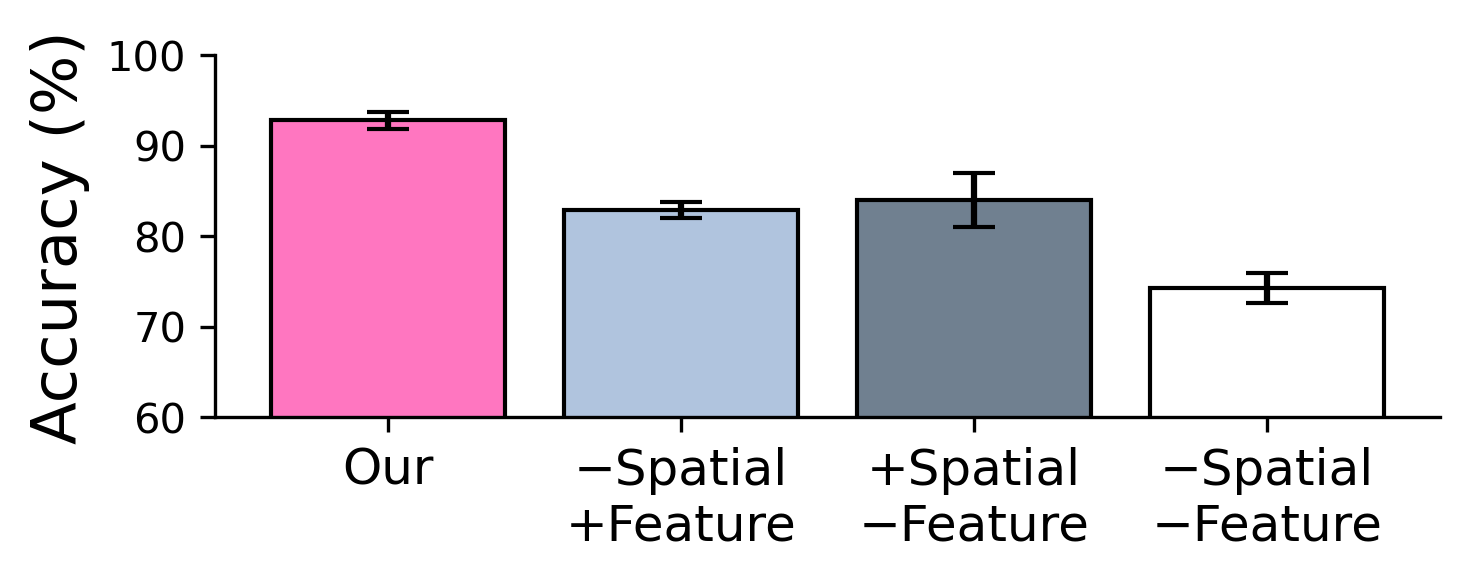

In [15]:
plt.rcParams["figure.figsize"] = (5,2)

labels = ['Our', u"\u2212" + 'Spatial\n' + 	u"\u002B" +'Feature', 	u"\u002B"+ 'Spatial\n'+ u"\u2212"+ 'Feature', u"\u2212"+'Spatial\n' +u"\u2212"+'Feature']

x =np.array([0, 0.5, 1, 1.5])  # the label locations
width = 0.4  # the width of the bars

fig, ax = plt.subplots(dpi=300)

# rects1 = ax.bar(x, means, width, yerr =ses, capsize=5,  edgecolor = 'black', color=['royalblue', 'lightsteelblue',  'slategrey', 'white'] )
rects1 = ax.bar(x, means, width, yerr =ses, capsize=5,  edgecolor = 'black', color=[colors[1], 'lightsteelblue',  'slategrey', 'white'] )

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Accuracy (%)', fontsize=15)
ax.set_title('')
ax.set_xticks(x, labels=labels, fontsize=12)
# ax.legend(fontsize=13)
ax.set_ylim(60, 100)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

# ax.bar_label(rects1, padding=3)
# ax.bar_label(rects2, padding=3)

plt.tight_layout()
plt.show()
fig.savefig("../results/figures/ablation_conv2_shape.pdf",   bbox_inches='tight')

In [16]:
print('<<<< Resnet')
path_modellist = [
    '../results/performance/acc-rrcapsnet-lowpass-resnet4-G5L3.csv',
    '../results/performance/acc-rrcapsnet-lowpass-resnet4-G1L3.csv',
    '../results/performance/acc-rrcapsnet-lowpass-resnet4-G5L1.csv',
    '../results/performance/acc-rrcapsnet-lowpass-resnet4-G1L1.csv',
]


# run stats
longdf=pd.DataFrame()
col1=[]
col2=[]
for name, path in zip(['our', 'nosp', 'noft', 'nono'], path_modellist):
    df = pd.read_csv(path)
    df.columns = ['corruption', 'run1', 'run2', 'run3', 'run4', 'run5']
    df = df[df['corruption'].isin(CORRUPTION_TYPES)]
    col1.extend([name]*5)
    col2.extend(df[['run1', 'run2', 'run3', 'run4', 'run5']].mean().tolist())

longdf['model'] = col1
longdf['acc'] = col2

aov = anova(dv='acc', between='model', data=longdf,detailed=True).round(3)
pairwise = pairwise_tests(dv='acc', between='model', padjust='bonf', data=longdf).round(3)
display(aov)
display(pairwise)

# prepare for visualizations
means, ses = [], []
for path_model in path_modellist:
    df = pd.read_csv(path_model)
    if df.iloc[:,-1].mean() < 1.0:
        print("changed to percent")
        df.iloc[:,1:] = df.iloc[:,1:]*100
    all_avg, all_std, shape_avg, shape_std = get_avg_std(df)
    means.append(shape_avg)
    ses.append(shape_std)

result = pd.DataFrame([means, ses], columns=['our', 'no spatial', 'no feature', 'no no'])
display(result)

<<<< Resnet


,Source,SS,DF,MS,F,p-unc,np2
0,model,99.179,3,33.060,12.609,0.0,0.703
1,Within,41.950,16,2.622,NaN,NaN,NaN


,Contrast,A,B,Paired,Parametric,T,dof,alternative,p-unc,p-corr,p-adjust,BF10,hedges
0,model,noft,nono,False,True,3.973,8.0,two-sided,0.004,0.025,bonf,9.674,2.269
1,model,noft,nosp,False,True,4.896,8.0,two-sided,0.001,0.007,bonf,23.796,2.797
2,model,noft,our,False,True,0.294,8.0,two-sided,0.776,1.000,bonf,0.506,0.168
3,model,nono,nosp,False,True,0.499,8.0,two-sided,0.631,1.000,bonf,0.532,0.285
4,model,nono,our,False,True,-3.792,8.0,two-sided,0.005,0.032,bonf,8.082,-2.166
5,model,nosp,our,False,True,-4.682,8.0,two-sided,0.002,0.009,bonf,19.388,-2.674


,our,no spatial,no feature,no no
0,96.24,90.1,96.2,90.00
1,0.74,2.0,0.5,2.14


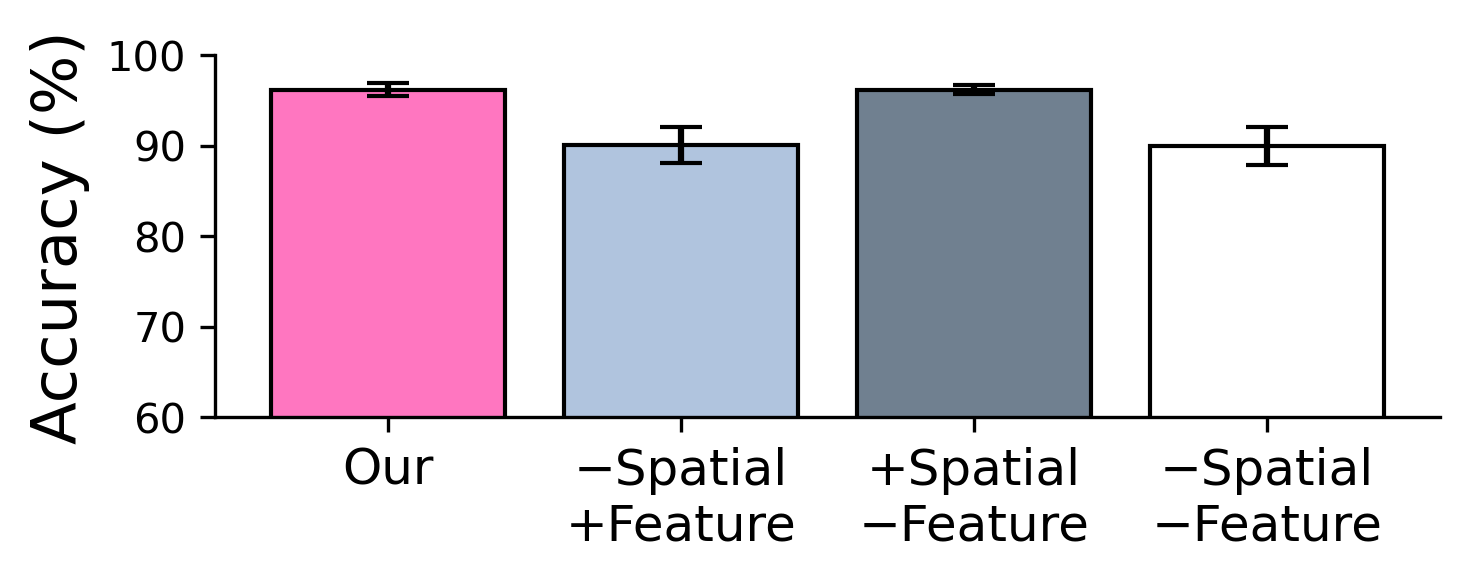

In [17]:
plt.rcParams["figure.figsize"] = (5,2)

labels = ['Our', u"\u2212" + 'Spatial\n' + 	u"\u002B" +'Feature', 	u"\u002B"+ 'Spatial\n'+ u"\u2212"+ 'Feature', u"\u2212"+'Spatial\n' +u"\u2212"+'Feature']

x =np.array([0, 0.5, 1, 1.5])  # the label locations
width = 0.4  # the width of the bars

fig, ax = plt.subplots(dpi=300)

# rects1 = ax.bar(x, means, width, yerr =ses, capsize=5,  edgecolor = 'black', color=['royalblue', 'lightsteelblue',  'slategrey', 'white'] )
rects1 = ax.bar(x, means, width, yerr =ses, capsize=5,  edgecolor = 'black', color=[colors[1], 'lightsteelblue',  'slategrey', 'white'] )

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Accuracy (%)', fontsize=15)
ax.set_title('')
ax.set_xticks(x, labels=labels, fontsize=12)
# ax.legend(fontsize=13)
ax.set_ylim(60, 100)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

# ax.bar_label(rects1, padding=3)
# ax.bar_label(rects2, padding=3)

plt.tight_layout()
plt.show()
fig.savefig("../results/figures/ablation_resnet4_shape.pdf",   bbox_inches='tight')


In [18]:
print('<< CONV')
# load two conditons for RT
path_modellist = [
    '../results/performance/rt-rrcapsnet-lowpass-conv2-G5L3.csv',
    '../results/performance/rt-rrcapsnet-lowpass-conv2-G5L1.csv',
]


# run stats
shortdf=pd.DataFrame()
for name, path in zip(['our', 'noft'], path_modellist):
    df = pd.read_csv(path)
    df.columns = ['corruption', 'run1', 'run2', 'run3', 'run4', 'run5']
    df = df[df['corruption'].isin(CORRUPTION_TYPES)]
    shortdf[name] = df[['run1', 'run2', 'run3', 'run4', 'run5']].mean().tolist()


display(ttest(shortdf['our'], shortdf['noft'], paired=False).round(3))


# prepare data for visualizations
means, ses = [], []
for path_model in path_modellist:
    df = pd.read_csv(path_model)
    if df.iloc[:,-1].mean() < 1.0:
        print("changed to percent")
        df.iloc[:,1:] = df.iloc[:,1:]*100
    all_avg, all_std, shape_avg, shape_std = get_avg_std(df)
    means.append(shape_avg)
    ses.append(shape_std)

result = pd.DataFrame([means, ses], columns=['our', 'no feature'])
display(result)





<< CONV


,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power
T-test,-30.185,8,two-sided,0.0,"[-0.48, -0.41]",19.091,2.096e+06,1.0


,our,no feature
0,4.52,4.94
1,0.03,0.01


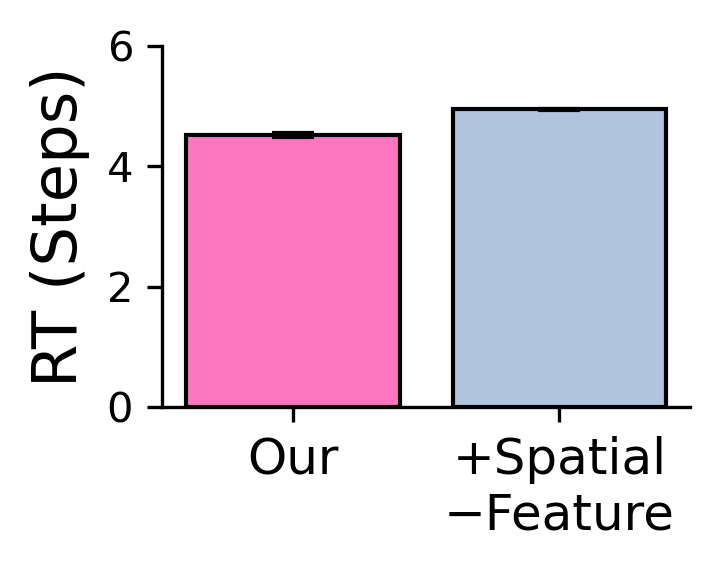

In [19]:
plt.rcParams["figure.figsize"] = (2.5,2)

labels = ['Our', u"\u002B"+ 'Spatial\n'+ u"\u2212"+ 'Feature']

x =np.array([0, 0.5])  # the label locations
width = 0.4  # the width of the bars

fig, ax = plt.subplots(dpi=300)

rects1 = ax.bar(x, means, width, yerr =ses, capsize=5,  edgecolor = 'black', color=[colors[1], 'lightsteelblue',  'slategrey', 'white'] )

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('RT (Steps)', fontsize=15)
ax.set_title('')
ax.set_xticks(x, labels=labels, fontsize=12)
# ax.legend(fontsize=13)
ax.set_ylim(0, 6)
# ax.set_ylim(0, 2)
# ax.set_yticks([0,1,2])
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

# ax.bar_label(rects1, padding=3)
# ax.bar_label(rects2, padding=3)

plt.tight_layout()
plt.show()
# fig.savefig("../results/figures/ablation_resnet4_shape_rt.pdf",   bbox_inches='tight')
fig.savefig("../results/figures/ablation_conv2_shape_rt.pdf",   bbox_inches='tight')

In [20]:
print('<< RESNET')
path_modellist = [
    '../results/performance/rt-rrcapsnet-lowpass-resnet4-G5L3.csv',
    '../results/performance/rt-rrcapsnet-lowpass-resnet4-G5L1.csv',
]

# run stats
shortdf=pd.DataFrame()
for name, path in zip(['our', 'noft'], path_modellist):
    df = pd.read_csv(path)
    df.columns = ['corruption', 'run1', 'run2', 'run3', 'run4', 'run5']
    df = df[df['corruption'].isin(CORRUPTION_TYPES)]
    shortdf[name] = df[['run1', 'run2', 'run3', 'run4', 'run5']].mean().tolist()


display(ttest(shortdf['our'], shortdf['noft'], paired=False).round(3))


# prepare data for visualizations
means, ses = [], []
for path_model in path_modellist:
    df = pd.read_csv(path_model)
    if df.iloc[:,-1].mean() < 1.0:
        print("changed to percent")
        df.iloc[:,1:] = df.iloc[:,1:]*100
    all_avg, all_std, shape_avg, shape_std = get_avg_std(df)
    means.append(shape_avg)
    ses.append(shape_std)

result = pd.DataFrame([means, ses], columns=['our', 'no feature'])
display(result)


<< RESNET


,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power
T-test,-10.207,8,two-sided,0.0,"[-0.51, -0.32]",6.455,1455.671,1.0


,our,no feature
0,1.26,1.52
1,0.02,0.06


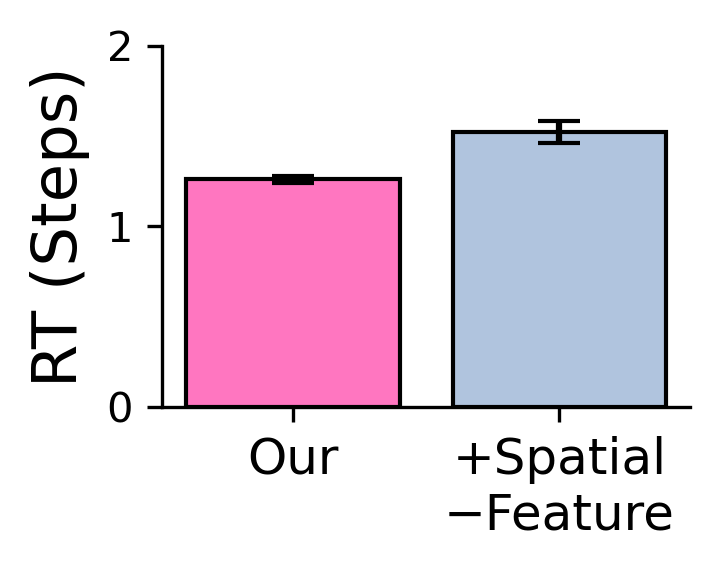

In [21]:
plt.rcParams["figure.figsize"] = (2.5,2)

labels = ['Our', u"\u002B"+ 'Spatial\n'+ u"\u2212"+ 'Feature']

x =np.array([0, 0.5])  # the label locations
width = 0.4  # the width of the bars

fig, ax = plt.subplots(dpi=300)

rects1 = ax.bar(x, means, width, yerr =ses, capsize=5,  edgecolor = 'black', color=[colors[1], 'lightsteelblue',  'slategrey', 'white'] )

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('RT (Steps)', fontsize=15)
ax.set_title('')
ax.set_xticks(x, labels=labels, fontsize=12)
# ax.legend(fontsize=13)
# ax.set_ylim(0, 6)
ax.set_ylim(0, 2)
ax.set_yticks([0,1,2])
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

# ax.bar_label(rects1, padding=3)
# ax.bar_label(rects2, padding=3)

plt.tight_layout()
plt.show()
fig.savefig("../results/figures/ablation_resnet4_shape_rt.pdf",   bbox_inches='tight')
# fig.savefig("../results/figures/ablation_conv2_shape_rt.pdf",   bbox_inches='tight')

# LSF vs HSF vs FS

In [10]:
# CORRUPTION_INTEREST=[
# #  'shear',
# #  'rotate',
# #  'scale',
# #  'translate',
# #  'stripe',
# #  'brightness',
# #  'canny_edges',
    
#  'glass_blur',
#  'motion_blur',
    
#  'impulse_noise',
#  'shot_noise',
        
#  'fog',
#  'dotted_line',    
#  'spatter',
#  'zigzag',
    

# ]

# get model avg and sd on shape set and add as separate columns to df
def get_avg_std(df):

    df.columns = ['corruption', 'run1', 'run2', 'run3', 'run4', 'run5']
    df = df[df['corruption'].isin(CORRUPTION_TYPES)]

    model_avg = df[['run1', 'run2', 'run3', 'run4', 'run5']].mean()
    all_avg = round(model_avg.mean(),2)
    all_std = round(model_avg.std(),2)
#     print('\n==All==\naverage: ', all_avg, '\nsd: ', all_std)

    df_select = df[df['corruption'].isin(CORRUPTION_INTEREST)].copy()

    model_avg = df_select[['run1', 'run2', 'run3', 'run4', 'run5']].mean()
    interest_avg = round(model_avg.mean(),2)
    interest_std = round(model_avg.std(),2)
#     print('\n==Shape==\naverage: ', interest_avg, '\nsd: ', interest_std)
    
    return all_avg, all_std, interest_avg, interest_std

In [13]:
path_modellist = [
    './performance/acc-rrcapsnet-lowpass-resnet4-G5L3.csv',
    './performance/acc-rrcapsnet-highpass-resnet4-G5L3.csv',
    './performance/acc-rrcapsnet-fullpass-resnet4-G5L3.csv',

#     './performance/rt-rrcapsnet-lowpass-resnet4-G5L3.csv',
#     './performance/rt-rrcapsnet-highpass-resnet4-G5L3.csv',
#     './performance/rt-rrcapsnet-fullpass-resnet4-G5L3.csv',    
]
means, ses = [], []
for path_model in path_modellist:
    df = pd.read_csv(path_model)
    if df.iloc[:,-1].mean() < 1.0:
        print("changed to percent")
        df.iloc[:,1:] = df.iloc[:,1:]*100
    all_avg, all_std, shape_avg, shape_std = get_avg_std(df)
    means.append(shape_avg) # shape_avg
    ses.append(shape_std) #shape_std

result = pd.DataFrame([means, ses], columns=['LSF', 'HSF', 'FS'], index=['mean', 'std'])
result

,LSF,HSF,FS
mean,96.24,94.73,96.38
std,0.74,0.67,0.45


In [72]:
path_modellist = [
    './performance/acc-rrcapsnet-lowpass-resnet4-G1L1.csv',
    './performance/acc-rrcapsnet-highpass-resnet4-G1L1.csv',
    './performance/acc-rrcapsnet-fullpass-resnet4-G1L1.csv',

#     './performance/rt-rrcapsnet-lowpass-resnet4-G1L1.csv',
#     './performance/rt-rrcapsnet-highpass-resnet4-G1L1.csv',
#     './performance/rt-rrcapsnet-fullpass-resnet4-G1L1.csv',    
]
means, ses = [], []
for path_model in path_modellist:
    df = pd.read_csv(path_model)
    if df.iloc[:,-1].mean() < 1.0:
        print("changed to percent")
        df.iloc[:,1:] = df.iloc[:,1:]*100
    all_avg, all_std, shape_avg, shape_std = get_avg_std(df)
    means.append(shape_avg)
    ses.append(shape_std)

result = pd.DataFrame([means, ses], columns=['LSF', 'HSF', 'FS'],  index=['mean', 'std'])
result

,LSF,HSF,FS
mean,90.00,89.01,89.62
std,2.14,1.26,2.59


# Archive

## On shape purturbed dataset

In [13]:
########################################################
# best model comparison on entire corruptions
########################################################
tasklist = ['mnist', 'mnist_occlusion', 'mnist_flipped', 'mnist_random']
verbose=False
print_args =False
args_to_update = {'device':DEVICE, 'batch_size':BATCHSIZE, 
                 'time_steps': 1, 'routings': 3, 'mask_threshold': 0.1}


modelpathlist = [
# './models/rrcapsnet/run1_epoch50_acc0.9917.pt',
# './models/rrcapsnet/run2_epoch50_acc0.9915.pt',
# './models/rrcapsnet/run3_epoch50_acc0.9907.pt',
# './models/rrcapsnet/run4_epoch50_acc0.9905.pt',
# './models/rrcapsnet/run5_epoch50_acc0.9907.pt',

# './results/mnist/Apr28_1352_adam_clr_128/archive_model_epoch50_acc0.9987.pt'
# './results/mnist/Apr28_1408_adam_clr_512/archive_model_epoch50_acc0.9953.pt' # increase bn worse
# './results/mnist/Apr28_1438_adam_clr_128_wde5/archive_model_epoch50_acc0.9986.pt'
# './results/mnist/Apr28_1458_adam_clr_128_wde4/archive_model_epoch50_acc0.9963.pt' #incerase weigthday worse
# './results/mnist/Apr28_1550_adamw_clr_128/archive_model_epoch50_acc0.9988.pt'
# './results/mnist/Apr28_1626_rmsprop_clr_128/archive_model_epoch50_acc0.9936.pt'
# './results/mnist/Apr28_1641_adam_exp_128/archive_model_epoch50_acc0.9979.pt'
# './results/mnist/Apr28_1719_adam_exp_128_lre3/archive_model_epoch50_acc0.9982.pt'
# './results/mnist/Apr28_1745_adam_exp_128_lre3_lamrecon5/archive_model_epoch50_acc0.9986.pt'
# './results/mnist/Apr28_1815_capsnetencoder_cycle/archive_model_epoch220_acc0.9961.pt'

# './results/mnist/Apr28_2001_shift_adamclr/archive_model_epoch50_acc0.9860.pt'

# Clean-CLR
# './results/mnist/Apr29_0212_clean_clr_run1/best_epoch174_acc0.9993.pt',
# './results/mnist/Apr29_0321_clean_clr_run2/best_epoch163_acc0.9993.pt',
# './results/mnist/Apr29_0427_clean_clr_run3/best_epoch186_acc0.9994.pt',
# './results/mnist/Apr29_0540_clean_clr_run4/best_epoch212_acc0.9995.pt',
# './results/mnist/Apr29_0703_clean_clr_run5/earlystop_245_acc0.9995.pt',
    
# Clean-WD
# './results/mnist/Apr29_0213_clean_wd_run1/best_epoch75_acc0.9981.pt',
# './results/mnist/Apr29_0247_clean_wd_run2/best_epoch81_acc0.9987.pt',
# './results/mnist/Apr29_0322_clean_wd_run3/best_epoch88_acc0.9987.pt',
# './results/mnist/Apr29_0400_clean_wd_run4/best_epoch62_acc0.9980.pt',
# './results/mnist/Apr29_0429_clean_wd_run5/best_epoch71_acc0.9987.pt',
    
# Clean-WD 0.0005, 0.98
# './results/mnist/Apr29_1353_clean_wd2_run1/best_epoch85_acc0.9983.pt',
# './results/mnist/Apr29_1435_clean_wd2_run2/best_epoch95_acc0.9986.pt',
# './results/mnist/Apr29_1704_clean_wd2_run3/best_epoch105_acc0.9988.pt',
# './results/mnist/Apr29_1749_clean_wd2_run4/best_epoch92_acc0.9983.pt',
# './results/mnist/Apr29_1829_clean_wd2_run5/best_epoch115_acc0.9987.pt',
    
# Recon-WD
# './results/mnist/Apr30_0144_recon_run1/best_epoch81_acc0.9983.pt',
# './results/mnist/Apr30_0208_recon_run2/best_epoch73_acc0.9986.pt',
# './results/mnist/Apr30_0230_recon_run3/best_epoch77_acc0.9986.pt',
# './results/mnist/Apr30_0253_recon_run4/best_epoch63_acc0.9981.pt',
# './results/mnist/Apr30_0321_recon_run5/best_epoch77_acc0.9987.pt',
    
# Shift-WD
# './results/mnist/Apr30_0304_shift_run1/best_epoch103_acc0.9966.pt',
# './results/mnist/Apr30_0400_shift_run2/best_epoch78_acc0.9977.pt',
# './results/mnist/Apr30_0425_shift_run3/best_epoch85_acc0.9973.pt',
# './results/mnist/Apr30_0450_shift_run4/best_epoch80_acc0.9958.pt',
# './results/mnist/Apr30_0513_shift_run5/best_epoch64_acc0.9978.pt'

]



df = pd.DataFrame()
df['task'] = tasklist

for load_model_path in modelpathlist:    
#     modelname = '-'.join( os.path.dirname(load_model_path).split('_')[-3:-1]) #'recon-step3'
    modelname = load_model_path.split('/')[-1] # filename
    print(f'test starts on {modelname}')
    
    # load args and model  
    args = load_args(load_model_path, args_to_update, print_args)
    model = load_model(args)
    
    acclist=[]
    for task in tasklist:
        _, _, _,acc = test_model(task, model, args)
        acclist.append(acc*100)
        
    df[load_model_path] = acclist

df

test starts on best_epoch81_acc0.9983.pt

=========== model instantiated like below: =============
TASK: mnist_recon (# targets: 1, # classes: 10, # background: 0)
TIMESTEPS #: 1
ENCODER: two-conv-layer w/ None projection
...resulting primary caps #: 1152, dim: 8
ROUTINGS # 3
Object #: 10, BG Capsule #: 0
DECODER: fcn, w/ None projection
...recon only one object capsule: True

original mnist dataset
test starts on best_epoch73_acc0.9986.pt

=========== model instantiated like below: =============
TASK: mnist_recon (# targets: 1, # classes: 10, # background: 0)
TIMESTEPS #: 1
ENCODER: two-conv-layer w/ None projection
...resulting primary caps #: 1152, dim: 8
ROUTINGS # 3
Object #: 10, BG Capsule #: 0
DECODER: fcn, w/ None projection
...recon only one object capsule: True

original mnist dataset
test starts on best_epoch77_acc0.9986.pt

=========== model instantiated like below: =============
TASK: mnist_recon (# targets: 1, # classes: 10, # background: 0)
TIMESTEPS #: 1
ENCODER: two-co

,task,./results/mnist/Apr30_0144_recon_run1/best_epoch81_acc0.9983.pt,./results/mnist/Apr30_0208_recon_run2/best_epoch73_acc0.9986.pt,./results/mnist/Apr30_0230_recon_run3/best_epoch77_acc0.9986.pt,./results/mnist/Apr30_0253_recon_run4/best_epoch63_acc0.9981.pt,./results/mnist/Apr30_0321_recon_run5/best_epoch77_acc0.9987.pt
0,mnist,99.030004,99.150004,99.060004,99.150005,99.110004
1,mnist_occlusion,91.280004,91.820006,91.260004,90.870005,91.760005
2,mnist_flipped,70.540003,70.250003,69.910004,70.620003,71.050004
3,mnist_random,36.190002,36.950002,35.900002,36.960001,36.730002


## For comparing models under the same experiment folder
obtain best model from each experiment and compare overall accuracy
- all pretrained models to be compared should be saved under the same folder 
- output is df file and will be saved to csv

In [3]:
##################
# set up info for model testing
##################
task='mnist_recon' #train on mnist_recon, test on mnistc_mini
task='mnist_c' #test on 15 benchmark corruption + 1 identity 

# get best model files under experiment path
path_experiment = './results/mnist/experiment-recon-norecon'
bestfiles, expnames = get_bestmodel_paths(path_experiment)
expname_format = ['use_recon','n_step', 'seed'] # what's writte n after timestamp
# expname_format = ['use_recon','n_step', 'inputmatch', 'seed']

# arguments to update
args_to_update = {'device':DEVICE, 'batch_size':BATCHSIZE, 
                 'time_steps': 4, 'routings': 3, 'routing_type': 'pd-recon', #'original' 
                 'min_coup': 0.5, 'min_rscore': 0.5, 'mask_threshold': 0.1}
print_args =False


##################
# main - model testing
##################

# create dataframe
df = pd.DataFrame()
df['model_path'] = bestfiles
df['exp_name'] = expnames
df[expname_format] = df['exp_name'].str.split('_',expand=True)
df['exp_name'] = df['exp_name'].str.split('_').str[:-1].str.join('_') #expname without seed

for i, row in df.iterrows():
    print(f'test begin on {i+1}th model')

    # load model
    load_model_path = row['model_path']   
    args = load_args(load_model_path, args_to_update, print_args)
    model = load_model(args)

    # test model
    if task == 'mnist_c':
        df.loc[i,'test_loss'], df.loc[i,'test_loss_class'], df.loc[i,'test_loss_recon'], df.loc[i,'test_acc'] = test_model_mnistc(PATH_MNISTC, CORRUPTION_TYPES, model)
    else:
        df.loc[i,'test_loss'], df.loc[i,'test_loss_class'], df.loc[i,'test_loss_recon'], df.loc[i,'test_acc'] = test_model(task, model, args)
    #     test_loss, test_loss_class, test_loss_recon, test_acc = test_model(model,args)
    
print('========== tests are done =============')

# save df
path_savefile = task + '-'+ os.path.basename(path_experiment) + '.csv'
if os.path.isfile(path_savefile):
    print(f'csv file already exists: {path_savefile}')
else: 
    df.to_csv(path_savefile)
    print(f'csv file saved: {path_savefile}')